In [1]:
# make the necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm

from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Identification of Cointegrated Pairs of Stocks

In [2]:
# read back the pricing data
prices = pd.read_csv('pharma.csv', index_col=['date'])
prices.head(10)

SUNPHARMA.NS   DRREDDY.NS  DIVISLAB.NS    CIPLA.NS    LUPIN.NS  \
date                                                                         
01-01-2018    574.049988  2404.149902  1099.050049  611.500000  883.250000   
02-01-2018    572.150024  2409.199951  1080.900024  607.799988  875.150024   
03-01-2018    569.049988  2339.000000  1099.400024  606.799988  878.950012   
04-01-2018    581.200012  2410.800049  1106.550049  616.750000  878.150024   
05-01-2018    578.750000  2473.399902  1107.650024  615.150024  900.150024   
08-01-2018    591.599976  2476.600098  1116.199951  615.049988  923.299988   
09-01-2018    586.500000  2457.800049  1089.300049  615.599976  923.250000   
10-01-2018    585.099976  2425.800049  1079.300049  619.750000  925.799988   
11-01-2018    587.950012  2425.350098  1101.550049  612.349976  929.200012   
12-01-2018    583.450012  2447.649902  1093.800049  612.099976  919.099976   

            LAURUSLABS.NS  AUROPHARMA.NS   BIOCON.NS     ALKEM.NS  
date                                                               
01-01-2018     107.919998     683.950012  269.000000  2225.949951  
02-01-2018     107.190002     671.400024  270.850006  2200.100098  
03-01-2018     107.370003     665.549988  270.924988  2213.050049  
04-01-2018     108.830002     668.299988  270.825012  2217.050049  
05-01-2018     110.290001     671.150024  270.475006  2220.300049  
08-01-2018     112.199997     677.349976  277.674988  2218.000000  
09-01-2018     110.699997     673.150024  272.750000  2222.100098  
10-01-2018     108.639999     672.700012  270.924988  2323.600098  
11-01-2018     110.050003     674.549988  273.125000  2287.250000  
12-01-2018     109.230003     667.049988  270.200012  2258.850098

In [3]:
# train test split 
train_close, test_close = train_test_split(prices, test_size=0.251012, shuffle=False)

In [4]:
# quick view of head and tail of train set
train_close.head(2).append(train_close.tail(2))

SUNPHARMA.NS   DRREDDY.NS  DIVISLAB.NS    CIPLA.NS    LUPIN.NS  \
date                                                                         
01-01-2018    574.049988  2404.149902  1099.050049  611.500000  883.250000   
02-01-2018    572.150024  2409.199951  1080.900024  607.799988  875.150024   
30-12-2020    584.000000  5170.950195  3799.699951  823.799988  977.599976   
31-12-2020    592.349976  5205.100098  3841.899902  819.950012  976.849976   

            LAURUSLABS.NS  AUROPHARMA.NS   BIOCON.NS     ALKEM.NS  
date                                                               
01-01-2018     107.919998     683.950012  269.000000  2225.949951  
02-01-2018     107.190002     671.400024  270.850006  2200.100098  
30-12-2020     350.049988     906.750000  458.700012  2928.449951  
31-12-2020     353.149994     921.299988  465.399994  2926.199951

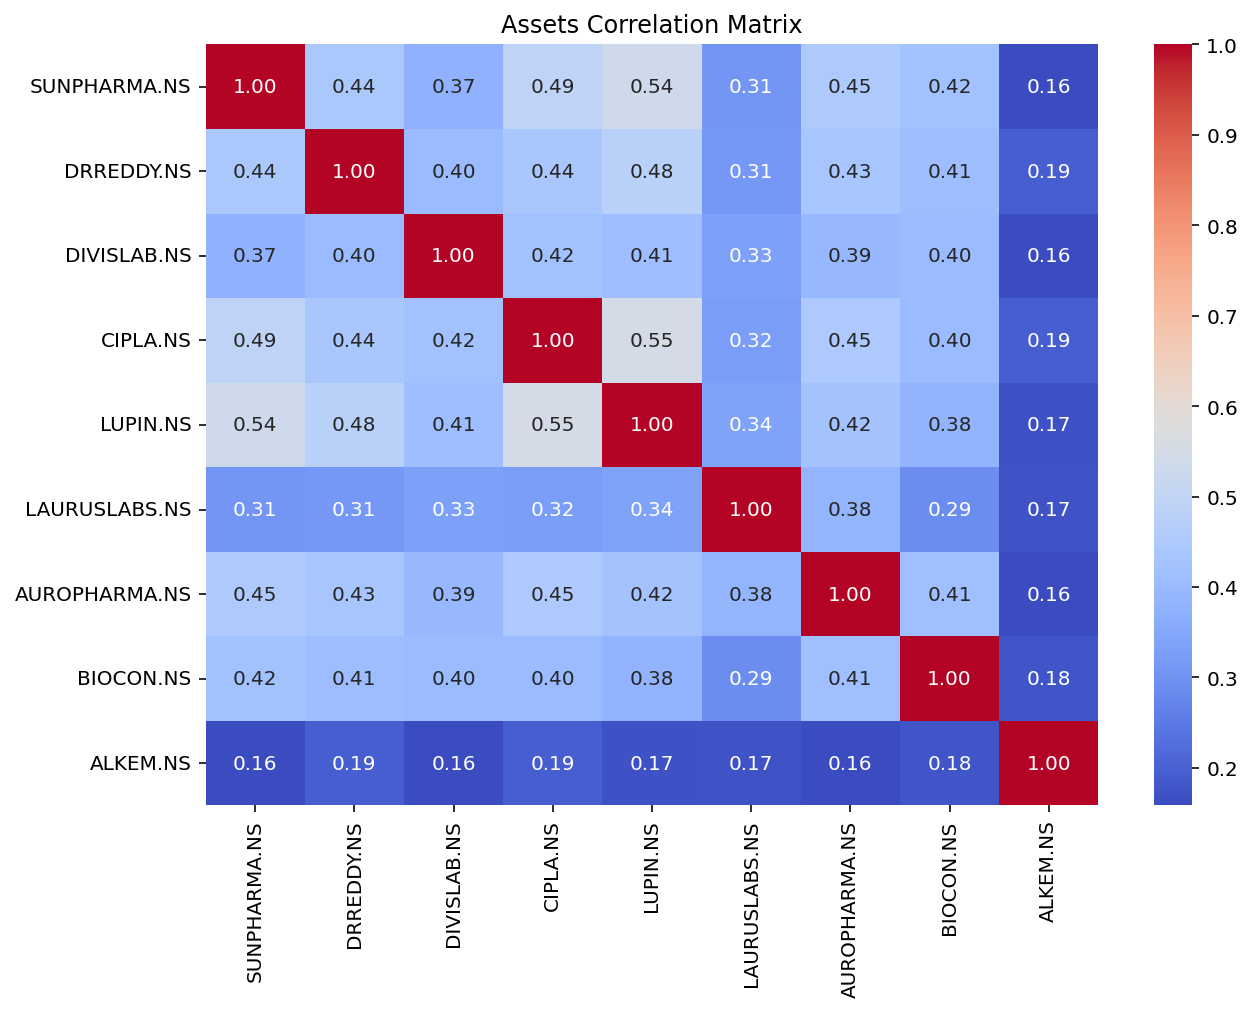

In [5]:
# Pearson correlation to get the basic idea about the relationship
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(train_close.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f") #spearman
ax.set_title('Assets Correlation Matrix')
plt.savefig('chart1', dpi=400)

In [6]:
# function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

[('DRREDDY.NS', 'DIVISLAB.NS'), ('LUPIN.NS', 'BIOCON.NS')]


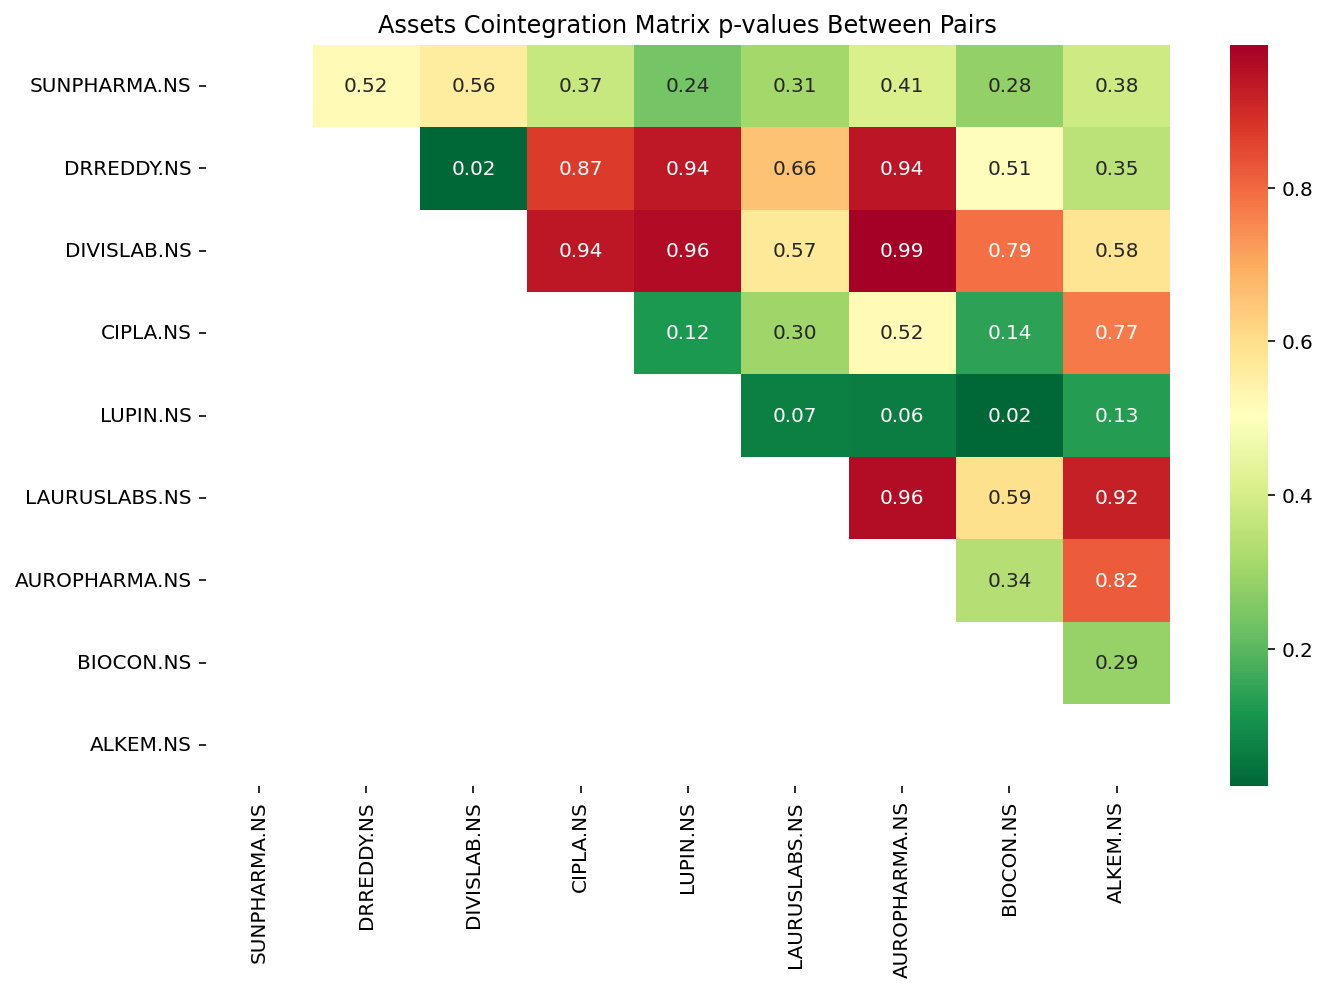

In [7]:
# calculate p-values and plot as a heatmap
pvalues, pairs = find_cointegrated_pairs(train_close)
print(pairs)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(pvalues, xticklabels = train_close.columns,
                yticklabels = train_close.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.99))
ax.set_title('Assets Cointegration Matrix p-values Between Pairs')
plt.tight_layout()
plt.savefig('chart2', dpi=400) 

### Perform a Cointegration test for the Selected Pair

In [8]:
# final pair to test strategy
asset1 = 'CIPLA.NS'
asset2 = 'BIOCON.NS'

In [9]:
# create a train dataframe of 2 assets
train = pd.DataFrame()
train['asset1'] = train_close[asset1]
train['asset2'] = train_close[asset2]

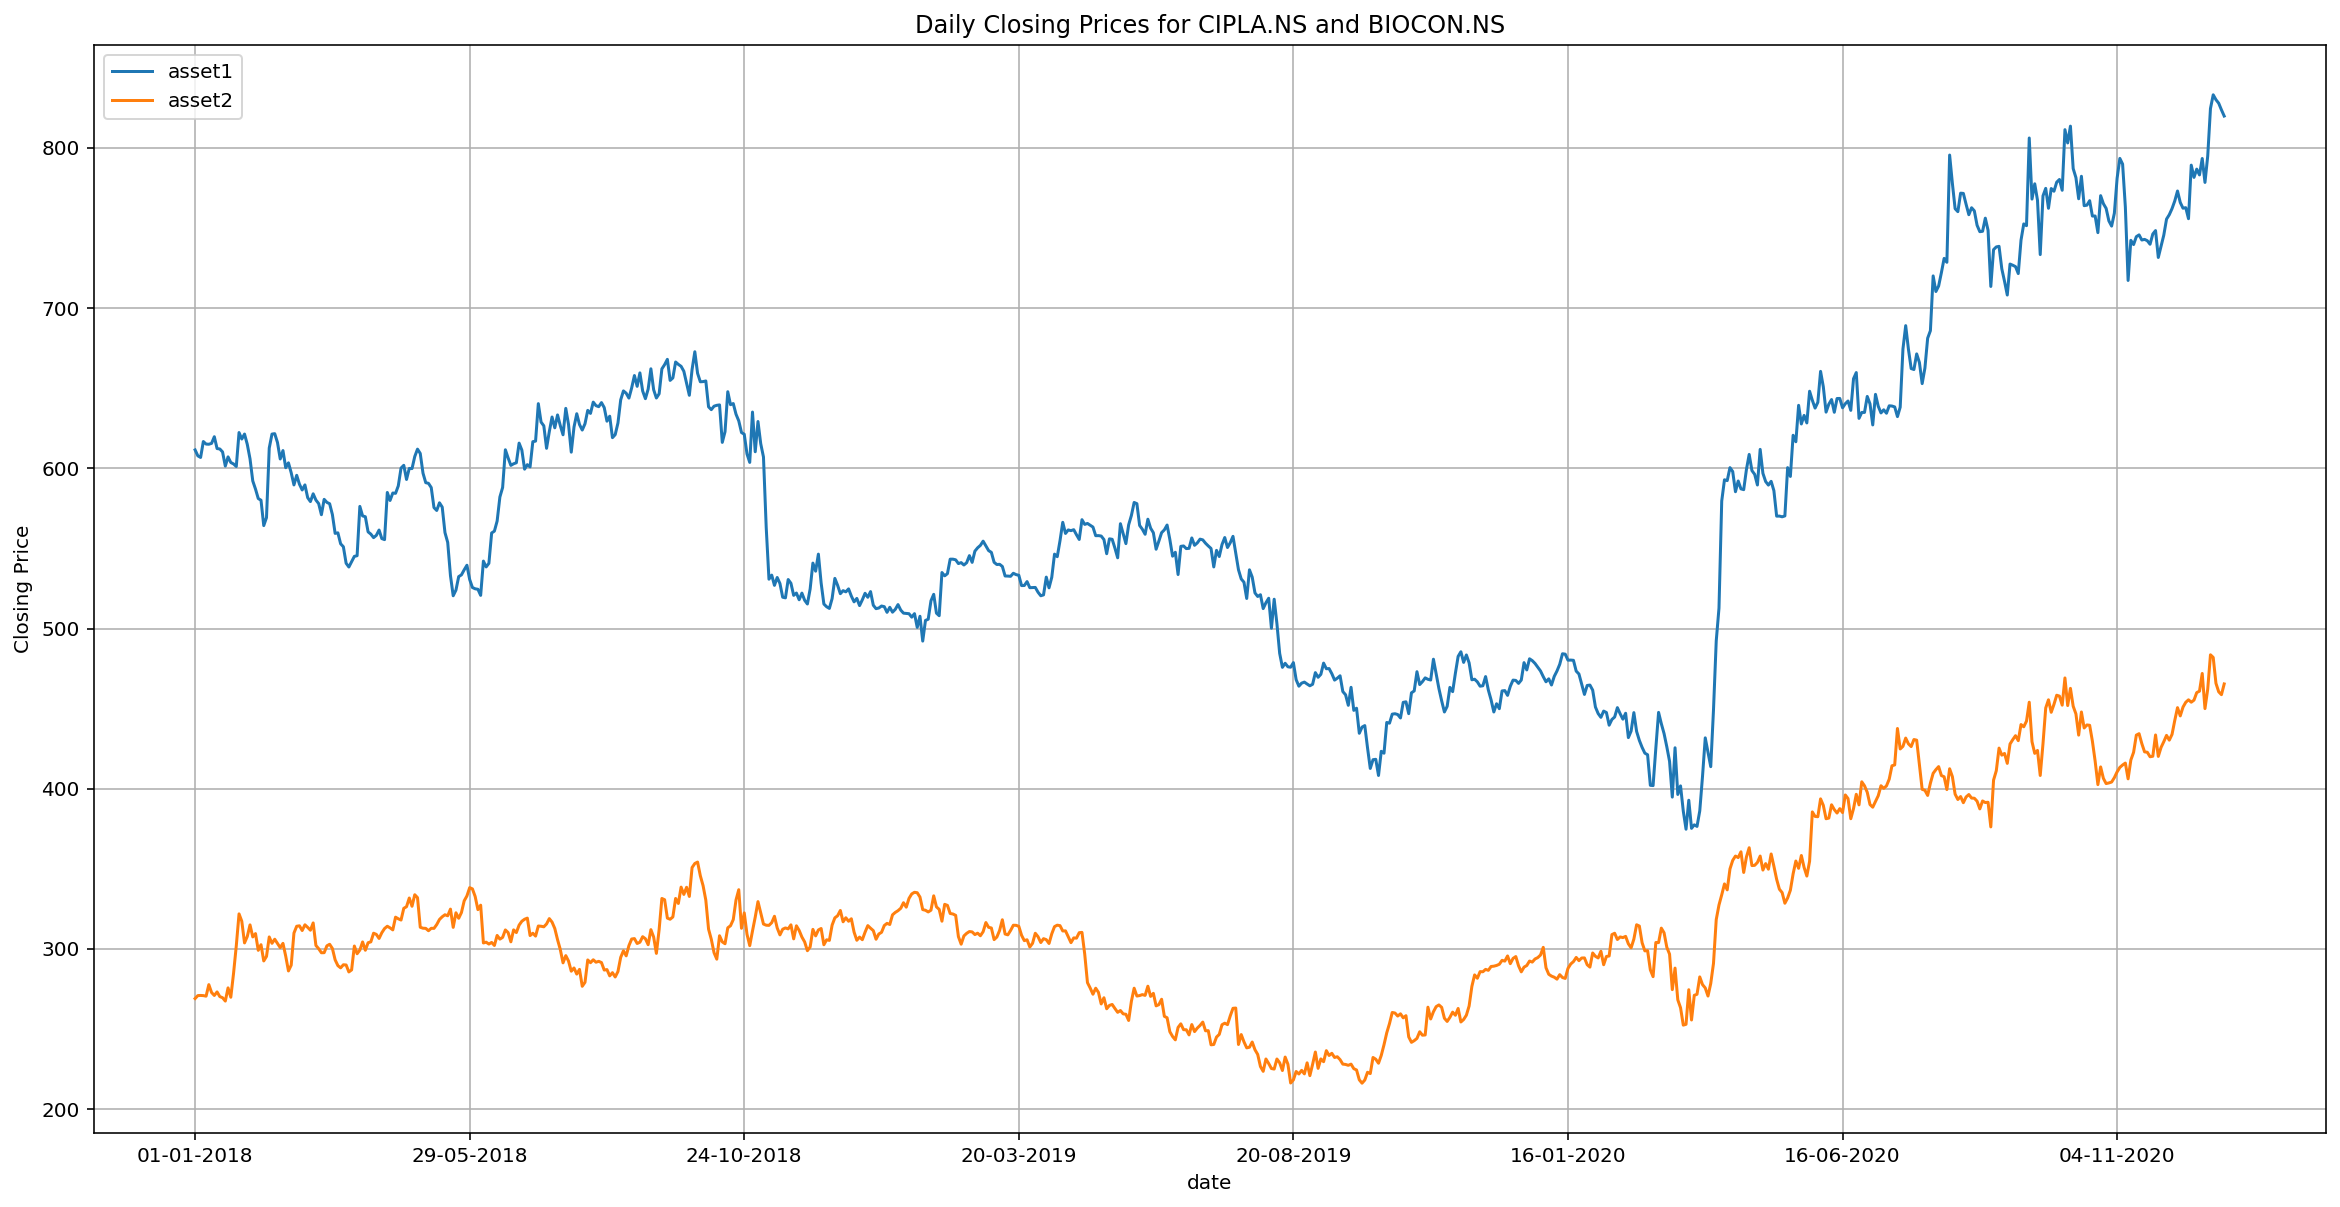

In [10]:
from matplotlib.dates import DateFormatter
# visualize closing prices
ax = train[['asset1','asset2']].plot(figsize=(20, 10), title = 'Daily Closing Prices for {} and {}'.format(asset1,asset2))
ax.set_ylabel("Closing Price")
#date_form = DateFormatter("%Y")
# ax.xaxis.set_major_formatter(date_form)
ax.grid(True);
plt.savefig('chart3', dpi=400) 

In [11]:
# run OLS regression
model=sm.OLS(train.asset2, train.asset1).fit()

In [12]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 asset2   R-squared (uncentered):                   0.988
Model:                            OLS   Adj. R-squared (uncentered):              0.988
Method:                 Least Squares   F-statistic:                          6.225e+04
Date:                Mon, 21 Mar 2022   Prob (F-statistic):                        0.00
Time:                        00:30:12   Log-Likelihood:                         -3685.8
No. Observations:                 740   AIC:                                      7374.
Df Residuals:                     739   BIC:                                      7378.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
asset1         0.5499      0.002    249.496      0.000       0.546       0.554
==============================================================================
Omnibus:                      100.098   Durbin-Watson:                   0.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.365
Skew:                          -0.126   Prob(JB):                     1.14e-06
Kurtosis:                       2.092   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
# print regression summary results
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)
plt.savefig('chart4', dpi=400);

In [14]:
print('Hedge Ratio = ', model.params[0])

Hedge Ratio =  0.5499205602956682


In [15]:
# calculate spread
spread = train.asset2 - model.params[0] * train.asset1

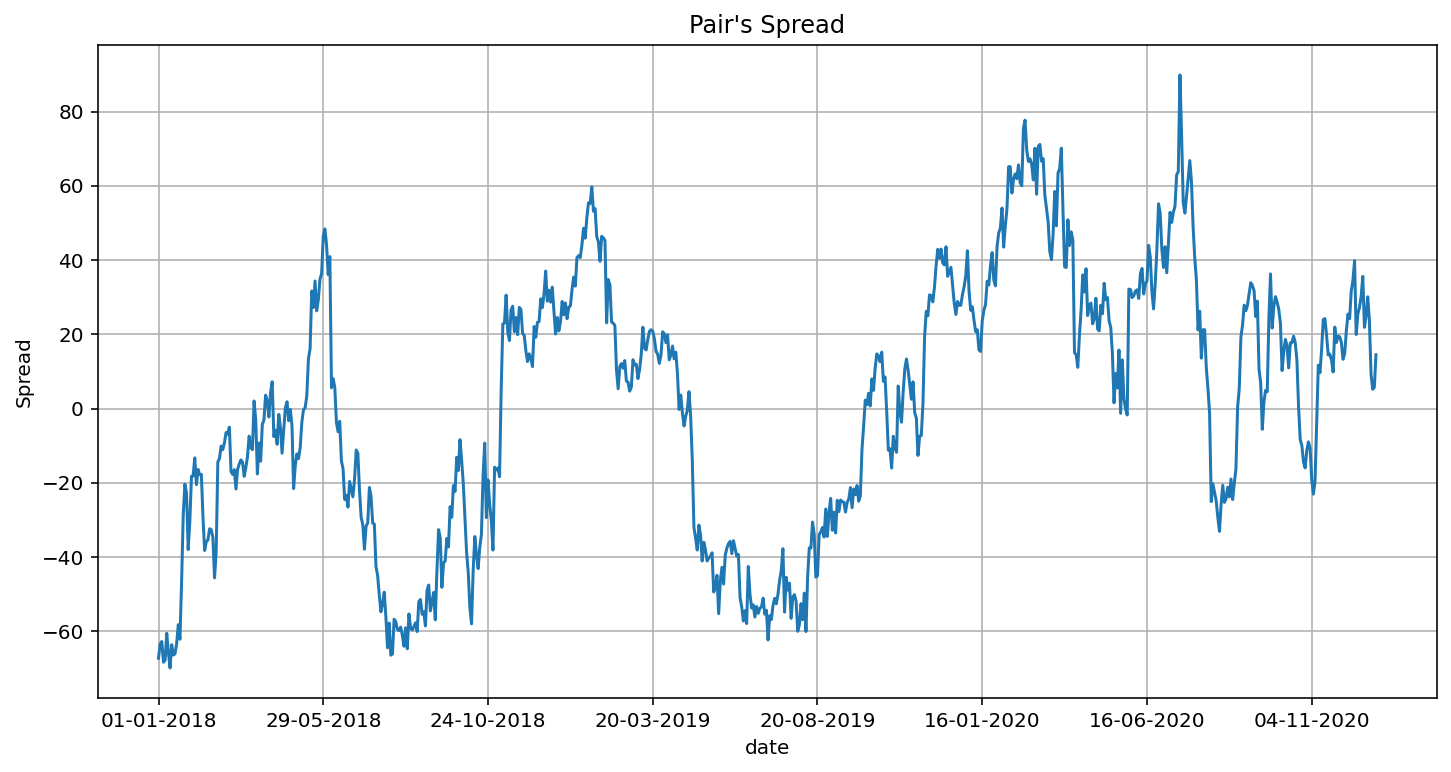

In [16]:
# Plot the spread
ax = spread.plot(figsize=(12, 6), title = "Pair's Spread")
ax.set_ylabel("Spread")
ax.grid(True);
plt.savefig('chart5', dpi=400);

In [17]:
# conduct Augmented Dickey-Fuller test
adf = adfuller(spread, maxlag = 1)
adf

(-3.0779691075952793,
 0.028227118226864554,
 0,
 739,
 {'1%': -3.439229783394421,
  '5%': -2.86545894814762,
  '10%': -2.5688568756191392},
 4978.099376897487)

In [18]:
print('Critical Value = ', adf[0])

Critical Value =  -3.0779691075952793


In [19]:
# probablity critical values
print(adf[4])

{'1%': -3.439229783394421, '5%': -2.86545894814762, '10%': -2.5688568756191392}


### Generate Trading Signals using z-score

In [20]:
# calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [21]:
# create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = test_close[asset1] 
signals['asset2'] = test_close[asset2]
ratios = signals.asset1 / signals.asset2

In [22]:
signals.head()

asset1      asset2
date                              
01-01-2021  826.599976  465.750000
04-01-2021  832.250000  467.000000
05-01-2021  827.250000  467.649994
06-01-2021  824.799988  459.750000
07-01-2021  826.549988  454.799988

In [23]:
# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

In [24]:
signals.head()

asset1      asset2         z  z upper limit  z lower limit
date                                                                      
01-01-2021  826.599976  465.750000 -2.265295            1.0           -1.0
04-01-2021  832.250000  467.000000 -2.236480            1.0           -1.0
05-01-2021  827.250000  467.649994 -2.288121            1.0           -1.0
06-01-2021  824.799988  459.750000 -2.189820            1.0           -1.0
07-01-2021  826.549988  454.799988 -2.098159            1.0           -1.0

In [25]:
# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

In [26]:
# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

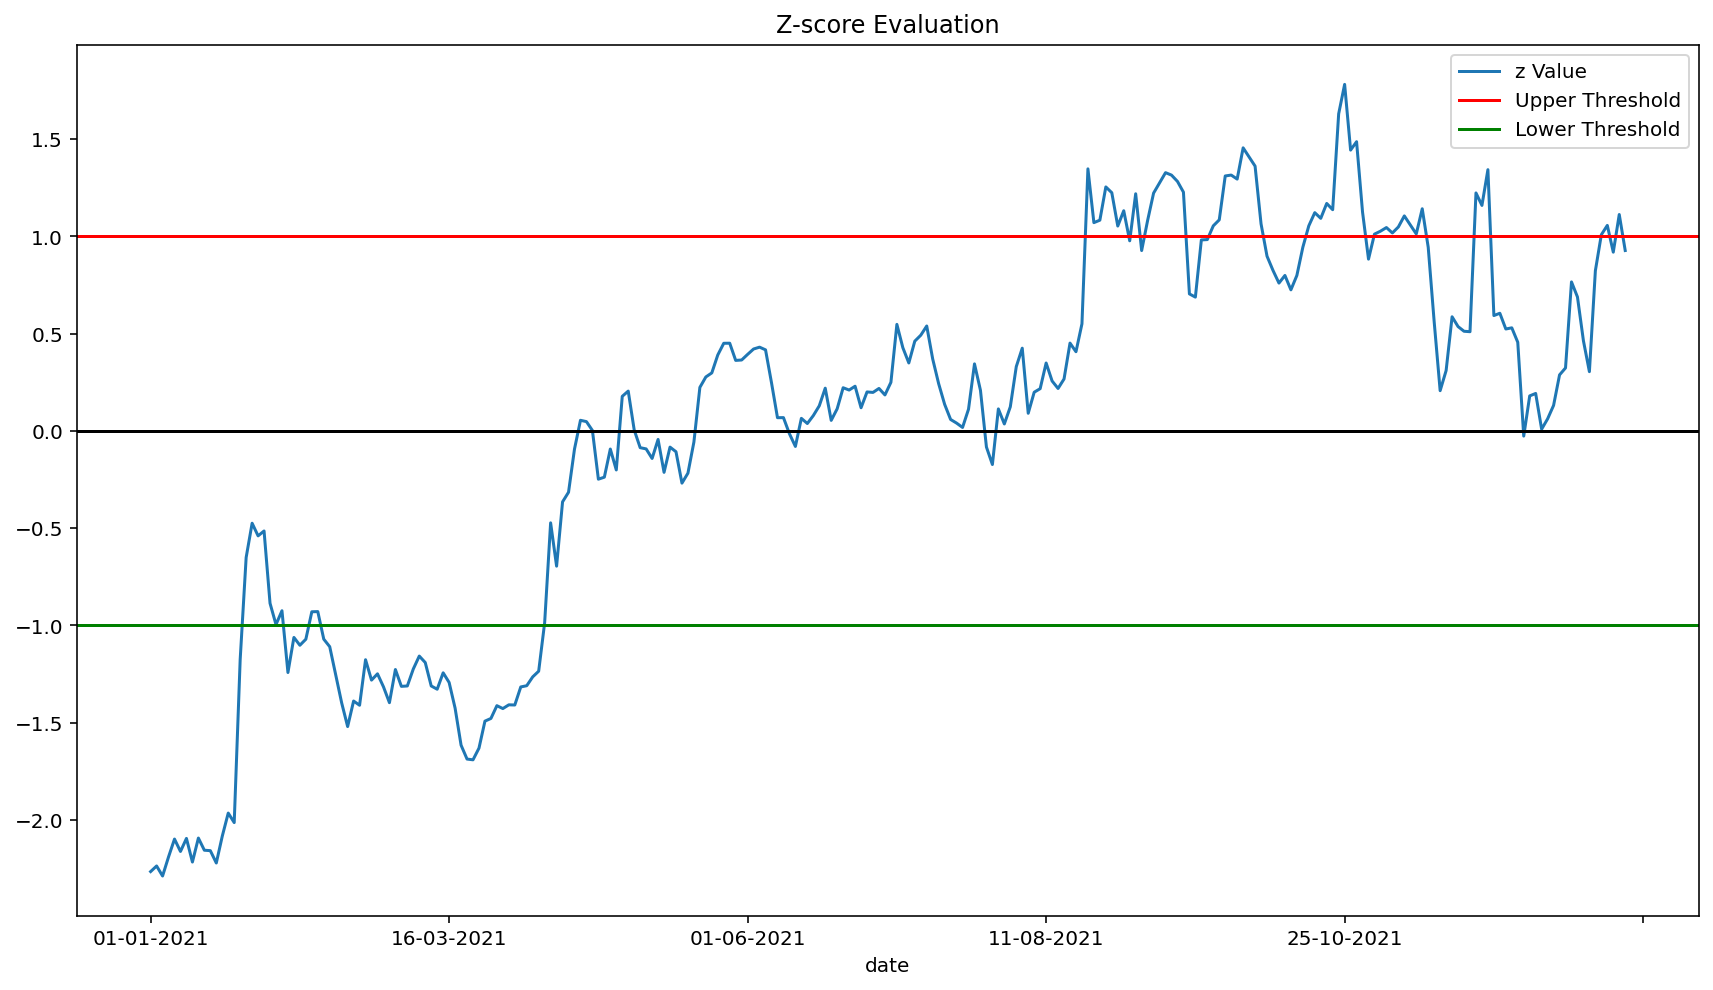

In [27]:
# # visualize z-score and upper and lower thresholds   
signals['z'].plot(label="z Value")
plt.title("Z-score Evaluation")
plt.axhline(signals['z'].mean(),color="black")
plt.axhline(signals['z upper limit'].mean(), color="red", label="Upper Threshold")
plt.axhline(signals['z lower limit'].mean(), color="green", label="Lower Threshold")
plt.legend()
plt.tight_layout()
plt.savefig('chart6', dpi=400);

In [28]:
# verify dataframe head and tail
signals.head(3).append(signals.tail(3))

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                         
01-01-2021  826.599976  465.750000 -2.265295            1.0           -1.0   
04-01-2021  832.250000  467.000000 -2.236480            1.0           -1.0   
05-01-2021  827.250000  467.649994 -2.288121            1.0           -1.0   
29-12-2021  935.549988  361.649994  0.919441            1.0           -1.0   
30-12-2021  952.750000  361.399994  1.113093            1.0           -1.0   
31-12-2021  944.099976  364.649994  0.927929            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         1         NaN        -1         NaN  
04-01-2021         1         0.0        -1         0.0  
05-01-2021         1         0.0        -1         0.0  
29-12-2021         0         1.0         0        -1.0  
30-12-2021        -1        -1.0         1         1.0  
31-12-2021         0         1.0         0        -1.0

In [29]:
# # check portfolio position
signals[signals.signals1 != 0].head(10)

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                         
01-01-2021  826.599976  465.750000 -2.265295            1.0           -1.0   
04-01-2021  832.250000  467.000000 -2.236480            1.0           -1.0   
05-01-2021  827.250000  467.649994 -2.288121            1.0           -1.0   
06-01-2021  824.799988  459.750000 -2.189820            1.0           -1.0   
07-01-2021  826.549988  454.799988 -2.098159            1.0           -1.0   
08-01-2021  838.700012  465.649994 -2.161899            1.0           -1.0   
11-01-2021  856.849976  471.250000 -2.094799            1.0           -1.0   
12-01-2021  843.150024  471.750000 -2.216239            1.0           -1.0   
13-01-2021  841.700012  462.799988 -2.092983            1.0           -1.0   
14-01-2021  840.900024  466.450012 -2.155518            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         1         NaN        -1         NaN  
04-01-2021         1         0.0        -1         0.0  
05-01-2021         1         0.0        -1         0.0  
06-01-2021         1         0.0        -1         0.0  
07-01-2021         1         0.0        -1         0.0  
08-01-2021         1         0.0        -1         0.0  
11-01-2021         1         0.0        -1         0.0  
12-01-2021         1         0.0        -1         0.0  
13-01-2021         1         0.0        -1         0.0  
14-01-2021         1         0.0        -1         0.0

In [30]:
signals[signals.positions1 != 0].head().append(signals[signals.positions1 != 0].tail())

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                         
01-01-2021  826.599976  465.750000 -2.265295            1.0           -1.0   
25-01-2021  836.799988  382.700012 -0.650432            1.0           -1.0   
04-02-2021  834.450012  409.899994 -1.241906            1.0           -1.0   
10-02-2021  863.400024  408.149994 -0.929526            1.0           -1.0   
12-02-2021  848.549988  408.049988 -1.070207            1.0           -1.0   
01-12-2021  928.150024  370.700012  0.593498            1.0           -1.0   
27-12-2021  930.250000  356.450012  1.009124            1.0           -1.0   
29-12-2021  935.549988  361.649994  0.919441            1.0           -1.0   
30-12-2021  952.750000  361.399994  1.113093            1.0           -1.0   
31-12-2021  944.099976  364.649994  0.927929            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         1         NaN        -1         NaN  
25-01-2021         0        -1.0         0         1.0  
04-02-2021         1         1.0        -1        -1.0  
10-02-2021         0        -1.0         0         1.0  
12-02-2021         1         1.0        -1        -1.0  
01-12-2021         0         1.0         0        -1.0  
27-12-2021        -1        -1.0         1         1.0  
29-12-2021         0         1.0         0        -1.0  
30-12-2021        -1        -1.0         1         1.0  
31-12-2021         0         1.0         0        -1.0

In [31]:
signals.loc[signals['positions1'] == 1].index
signals['asset1'][signals['positions1'] == 1].value_counts()

834.450012    1
848.549988    1
922.849976    1
941.099976    1
954.000000    1
934.549988    1
905.049988    1
938.150024    1
928.150024    1
935.549988    1
944.099976    1
Name: asset1, dtype: int64

In [32]:
signals

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                         
01-01-2021  826.599976  465.750000 -2.265295            1.0           -1.0   
04-01-2021  832.250000  467.000000 -2.236480            1.0           -1.0   
05-01-2021  827.250000  467.649994 -2.288121            1.0           -1.0   
06-01-2021  824.799988  459.750000 -2.189820            1.0           -1.0   
07-01-2021  826.549988  454.799988 -2.098159            1.0           -1.0   
...                ...         ...       ...            ...            ...   
27-12-2021  930.250000  356.450012  1.009124            1.0           -1.0   
28-12-2021  933.299988  355.950012  1.057101            1.0           -1.0   
29-12-2021  935.549988  361.649994  0.919441            1.0           -1.0   
30-12-2021  952.750000  361.399994  1.113093            1.0           -1.0   
31-12-2021  944.099976  364.649994  0.927929            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         1         NaN        -1         NaN  
04-01-2021         1         0.0        -1         0.0  
05-01-2021         1         0.0        -1         0.0  
06-01-2021         1         0.0        -1         0.0  
07-01-2021         1         0.0        -1         0.0  
...              ...         ...       ...         ...  
27-12-2021        -1        -1.0         1         1.0  
28-12-2021        -1         0.0         1         0.0  
29-12-2021         0         1.0         0        -1.0  
30-12-2021        -1        -1.0         1         1.0  
31-12-2021         0         1.0         0        -1.0  

[248 rows x 9 columns]

In [33]:
signals = signals.reset_index()

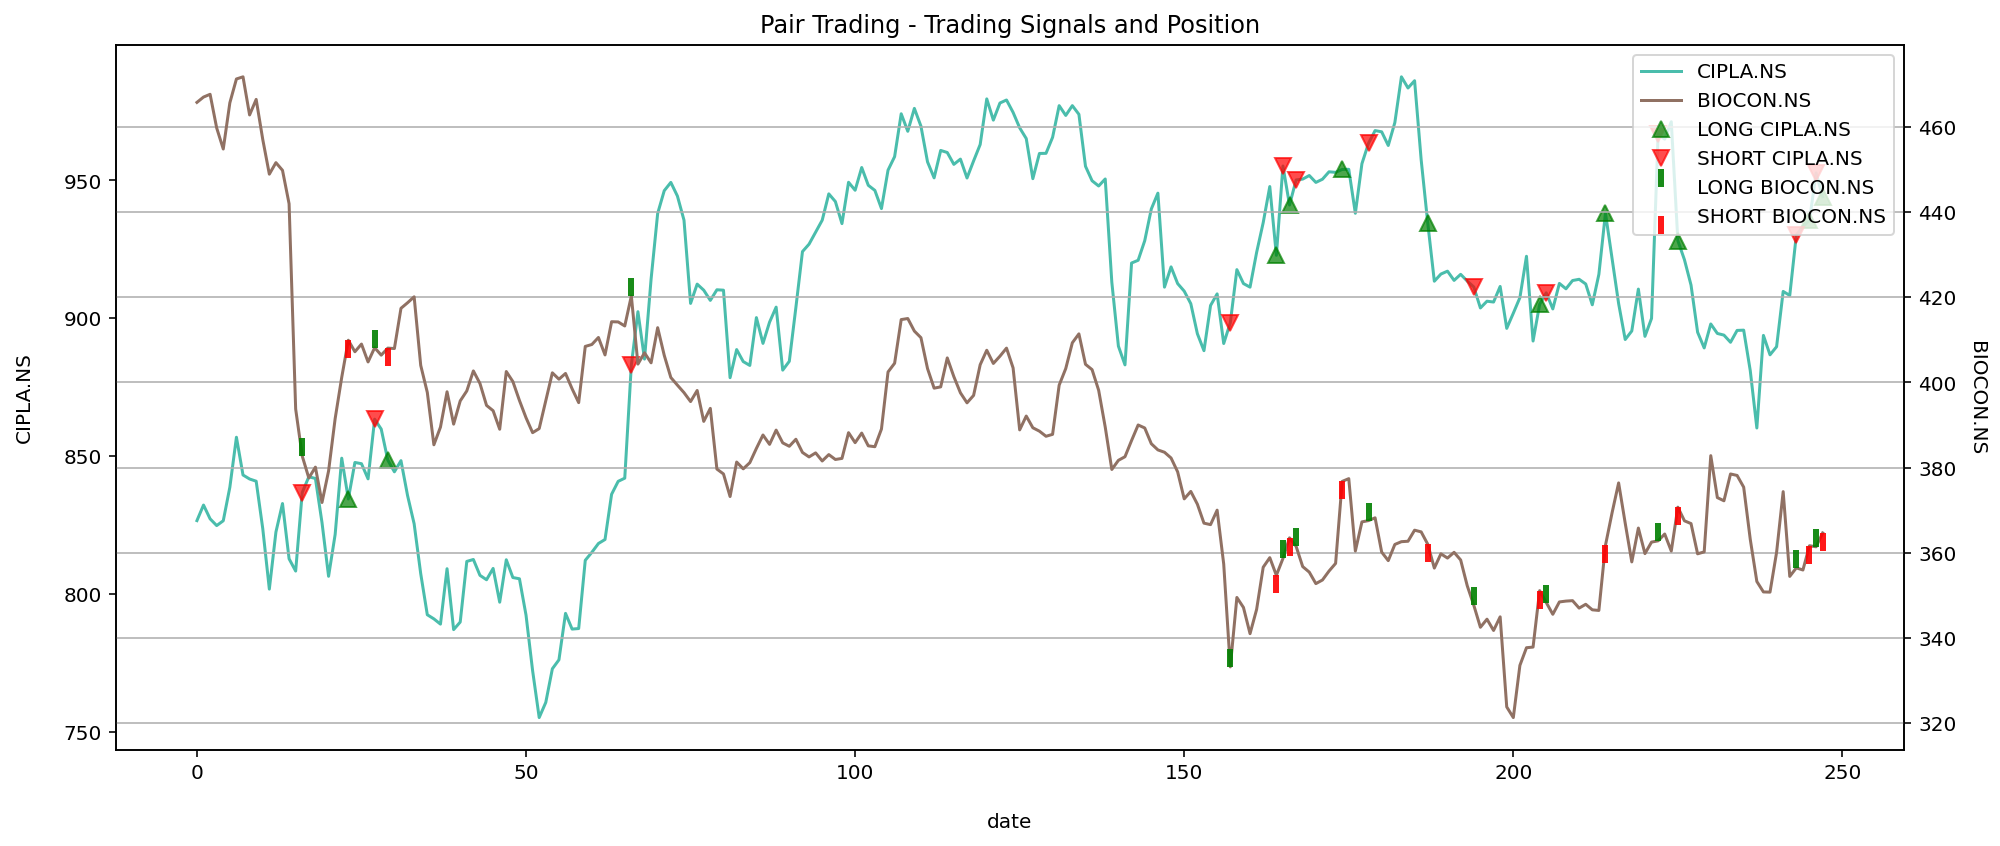

In [34]:
# visualize trading signals and position
fig=plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['asset1'], c='#4abdac')
l2, = bx2.plot(signals['asset2'], c='#907163')

u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)

d1, = bx.plot(signals['asset1'][signals['positions1'] == -1], lw=0,marker='v',markersize=8, c='r',alpha=0.7)

u2, = bx2.plot(signals['asset2'][signals['positions2'] == 1], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)

d2, = bx2.plot(signals['asset2'][signals['positions2'] == -1], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)

bx.set_ylabel(asset1,)
bx2.set_ylabel(asset2, rotation=270)
bx.yaxis.labelpad=15
bx2.yaxis.labelpad=15
bx.set_xlabel('date')
# bx.xaxis.set_major_formatter(DateFormatter("%Y"))
# bx2.xaxis.set_major_formatter(DateFormatter("%Y"))
bx.xaxis.labelpad=15

plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'LONG {}'.format(asset1),
           'SHORT {}'.format(asset1),
           'LONG {}'.format(asset2),
           'SHORT {}'.format(asset2)], loc ='best')

plt.title('Pair Trading - Trading Signals and Position')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.savefig('chart7', dpi=400);

### Portfolio Profit and Loss Calculation

In [35]:
# initial capital to calculate the actual pnl
initial_capital = 100000

# shares to buy for each position
positions1 = initial_capital// max(signals['asset1'])
positions2 = initial_capital// max(signals['asset2'])

In [36]:
# since there are two assets, we calculate each asset Pnl separately 
# and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']

In [37]:
portfolio.head().append(portfolio.tail())

asset1      holdings1          cash1   total asset1   return1  \
0    826.599976            NaN            NaN            NaN       NaN   
1    832.250000       0.000000  100000.000000  100000.000000       NaN   
2    827.250000       0.000000  100000.000000  100000.000000  0.000000   
3    824.799988       0.000000  100000.000000  100000.000000  0.000000   
4    826.549988       0.000000  100000.000000  100000.000000  0.000000   
243  930.250000 -187910.500000  287986.250000  100075.750000 -0.021673   
244  933.299988 -188526.597536  287986.250000   99459.652464 -0.006156   
245  935.549988  -94490.548768  193495.701232   99005.152464 -0.004570   
246  952.750000 -192455.500000  289723.451232   97267.951232 -0.017547   
247  944.099976  -95354.097536  194369.353697   99015.256161  0.017964   

     positions1  
0           NaN  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
243        -1.0  
244         0.0  
245         1.0  
246        -1.0  
247         1.0

In [38]:
portfolio[portfolio.positions1 != 0].head()

asset1     holdings1          cash1   total asset1       return1  \
0   826.599976           NaN            NaN            NaN           NaN   
16  836.799988 -84516.798768  184516.798768  100000.000000  0.000000e+00   
23  834.450012      0.000000  100237.347536  100237.347536  1.513834e-02   
27  863.400024 -87203.402464  187440.750000  100237.347536 -1.110223e-16   
29  848.549988      0.000000  101737.201232  101737.201232  1.129462e-02   

    positions1  
0          NaN  
16        -1.0  
23         1.0  
27        -1.0  
29         1.0

In [39]:
# pnl for the 2nd asset
portfolio['asset2'] = signals['asset2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

In [40]:
portfolio.to_csv('portfolio.csv')
portfolio.head().append(portfolio.tail())

asset1      holdings1          cash1   total asset1   return1  \
0    826.599976            NaN            NaN            NaN       NaN   
1    832.250000       0.000000  100000.000000  100000.000000       NaN   
2    827.250000       0.000000  100000.000000  100000.000000  0.000000   
3    824.799988       0.000000  100000.000000  100000.000000  0.000000   
4    826.549988       0.000000  100000.000000  100000.000000  0.000000   
243  930.250000 -187910.500000  287986.250000  100075.750000 -0.021673   
244  933.299988 -188526.597536  287986.250000   99459.652464 -0.006156   
245  935.549988  -94490.548768  193495.701232   99005.152464 -0.004570   
246  952.750000 -192455.500000  289723.451232   97267.951232 -0.017547   
247  944.099976  -95354.097536  194369.353697   99015.256161  0.017964   

     positions1      asset2      holdings2          cash2   total asset2  \
0           NaN  465.750000            NaN            NaN            NaN   
1           0.0  467.000000       0.000000  100000.000000  100000.000000   
2           0.0  467.649994       0.000000  100000.000000  100000.000000   
3           0.0  459.750000       0.000000  100000.000000  100000.000000   
4           0.0  454.799988       0.000000  100000.000000  100000.000000   
243        -1.0  356.450012  150421.905148  -45336.790990  105085.114158   
244         0.0  355.950012  150210.905148  -45336.790990  104874.114158   
245         1.0  361.649994   76308.148713   30971.357723  107279.506435   
246        -1.0  361.399994  152510.797426  -45284.040990  107226.756435   
247         1.0  364.649994   76941.148713   31657.107723  108598.256435   

      return2  positions2  
0         NaN         NaN  
1         NaN         0.0  
2    0.000000         0.0  
3    0.000000         0.0  
4    0.000000         0.0  
243  0.004032         1.0  
244 -0.002008         0.0  
245  0.022936        -1.0  
246 -0.000492         1.0  
247  0.012791        -1.0

In [41]:
portfolio[portfolio.positions2 != 0].head()

asset1     holdings1          cash1   total asset1       return1  \
0   826.599976           NaN            NaN            NaN           NaN   
16  836.799988 -84516.798768  184516.798768  100000.000000  0.000000e+00   
23  834.450012      0.000000  100237.347536  100237.347536  1.513834e-02   
27  863.400024 -87203.402464  187440.750000  100237.347536 -1.110223e-16   
29  848.549988      0.000000  101737.201232  101737.201232  1.129462e-02   

    positions1      asset2     holdings2          cash2   total asset2  \
0          NaN  465.750000           NaN            NaN            NaN   
16        -1.0  382.700012  80749.702574   19250.297426  100000.000000   
23         1.0  409.899994      0.000000  105739.196139  105739.196139   
27        -1.0  408.149994  86119.648713   19619.547426  105739.196139   
29         1.0  408.049988      0.000000  105718.094852  105718.094852   

     return2  positions2  
0        NaN         NaN  
16  0.000000         1.0  
23  0.017667        -1.0  
27  0.000000         1.0  
29  0.003304        -1.0

In [42]:
# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

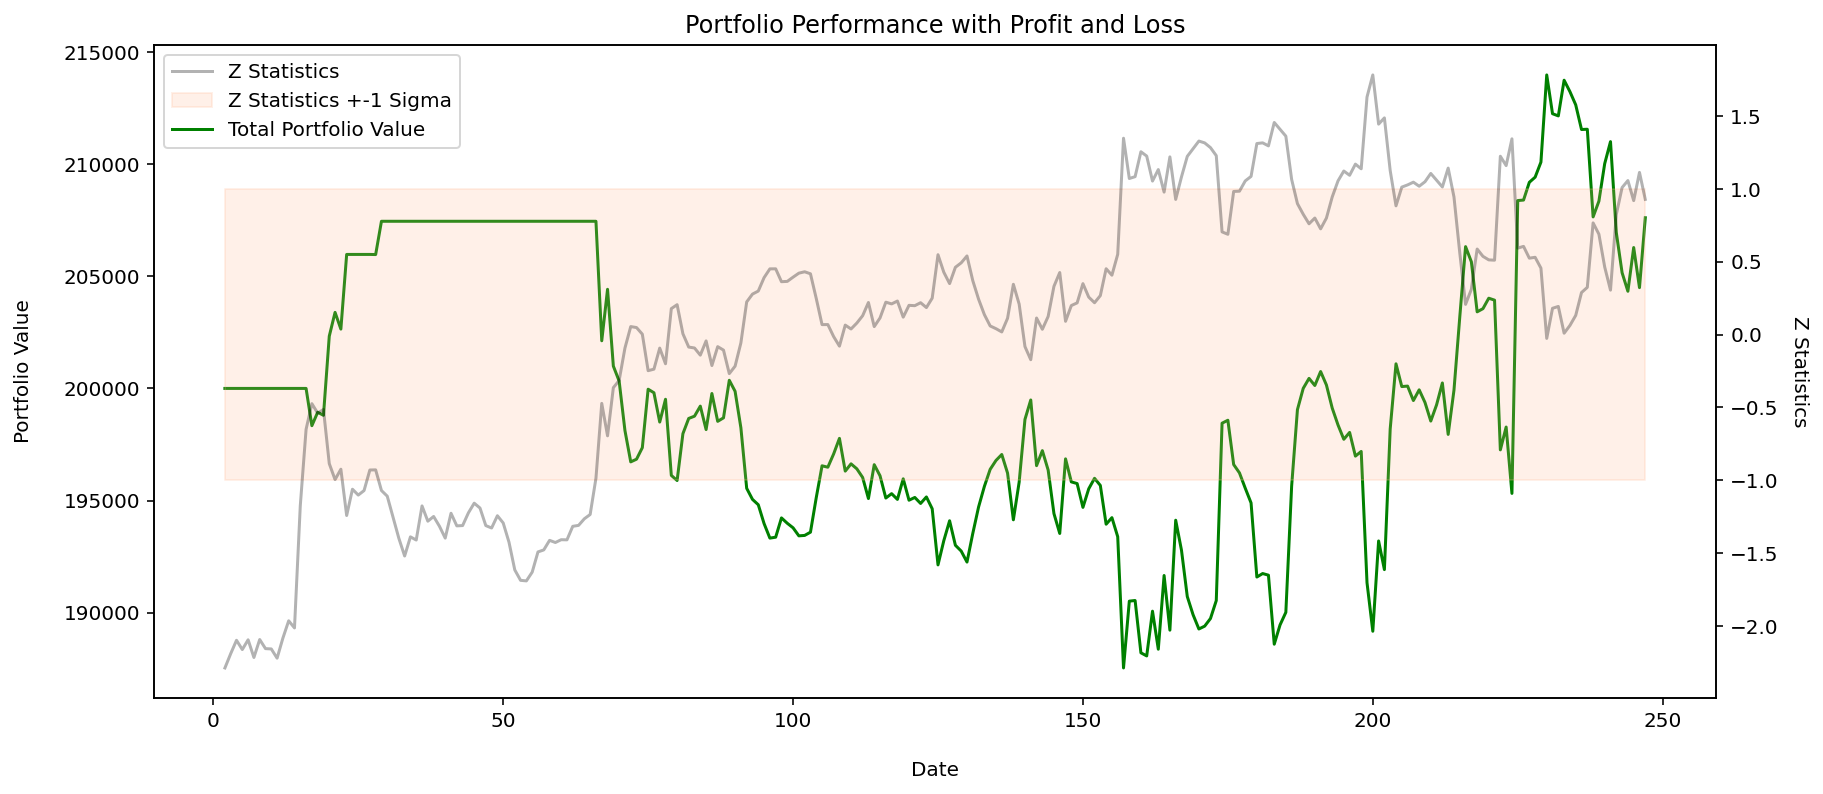

In [43]:
# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(14,6),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()

l1, = ax.plot(portfolio['total asset'], c='g')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)

b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')

ax.set_ylabel('Portfolio Value')
ax2.set_ylabel('Z Statistics',rotation=270)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.xaxis.labelpad=15
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');
plt.savefig('chart8', dpi=400);

In [44]:
#portfolio = pd.read_csv('portfolio.csv')

In [47]:
# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
final_portfolio

207613.5125965

In [48]:
profit = final_portfolio - 2*initial_capital
profit

7613.51259649999

In [49]:
roi = (profit/(2*initial_capital))*100
roi

3.806756298249995

In [50]:
# delta = (portfolio.index[-1] - portfolio.index[0]).days
delta = (portfolio.index[-1] - portfolio.index[0])
print('Number of days = ', delta)

Number of days =  245


In [51]:
YEAR_DAYS = 365
returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

CAGR = 196.925%
